In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot
import tensorflow as tf
import pickle
import os
from importlib import reload

In [27]:
import dataset_utils
from glob import glob

In [28]:
reload(dataset_utils)

<module 'dataset_utils' from 'c:\\Users\\kzho904\\Documents\\GitHub\\P4P-mmWave\\MMWave_Radar_Human_Tracking_and_Fall_detection\\dataset_utils.py'>

In [29]:
bg_noise_dir = './data/03_09_2024_katie_pc_bg_noise/unique_bg_points.pkl'
with open(bg_noise_dir, 'rb') as file:
        background_data = pickle.load(file)

In [30]:
def background_subtraction(background_data, current_frame_data, threshold=0.1):
    filtered_data = []
    points_removed = []
    num_points_removed = 0
    for point in current_frame_data:
        # print(point)
        distances = np.linalg.norm(background_data[:, :3]- point[:3], axis =1)
        if np.min(distances) > threshold:
            filtered_data.append(point)
        else:
            num_points_removed +=1
            points_removed.append(point)
    return filtered_data

In [31]:
def normalise_array(filtered_data):
        filtered_data = np.array(filtered_data)
        min_values = filtered_data.min(axis=0)
        max_values = filtered_data.max(axis=0)
        
        # Handle cases where max and min are the same
        range_values = max_values - min_values
        range_values[range_values == 0] = 1  # Prevent division by zero

        # Apply Min-Max normalization
        normalized_data = (filtered_data - min_values) / range_values

        return normalized_data

In [32]:
from sklearn.preprocessing import StandardScaler
def standardise_array(current_frame_data):
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(current_frame_data)

    return standardized_data

In [33]:
def parse_dataset(num_points, DATA_DIR):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob(os.path.join(folder, "train/*"))
        test_files = glob(os.path.join(folder, "test/*"))

        all_train_points=[]
        for f in train_files:
            with open(f, 'rb') as file:
                data = pickle.load(file)
                for arr in data:
                    #bg_rm
                    bg_rm_arr = background_subtraction(background_data, arr)
                    
                    #standardise 
                    bg_rm_arr = standardise_array(bg_rm_arr)

                    #normalise 
                    # bg_rm_arr = normalise_array(bg_rm_arr)
                    all_train_points.append(bg_rm_arr)
                
                concatenated_train_points = np.concatenate(all_train_points, axis=0)
                # concatenated_train_points = background_subtraction(background_data, concatenated_train_points)
                np.random.seed(42)
                sampled_indices = np.random.choice(concatenated_train_points.shape[0], size=num_points, replace=True)
                sampled_data = concatenated_train_points[sampled_indices].astype(np.float16)
                train_points.append(sampled_data)
                train_labels.append(i)
                # print(data)
                # print("loaded: {}".format(f))
                # print(num_points)
                # sampled_data = data.sample(num_points).to_numpy()
               
        all_test_points = []
        for f in test_files:
            with open(f, 'rb') as file:
                data = pickle.load(file)
                for arr in data:
                    #bg_rm
                    bg_rm_arr = background_subtraction(background_data, arr)
                    
                    #standardise 
                    bg_rm_arr = standardise_array(bg_rm_arr)

                    #normalise 
                    # bg_rm_arr = normalise_array(bg_rm_arr)
                    all_test_points.append(bg_rm_arr)
                    
                concatenated_test_points = np.concatenate(all_test_points, axis=0)
                # concatenated_test_points = background_subtraction(background_data, concatenated_test_points)
                np.random.seed(42)
                sampled_indices = np.random.choice(concatenated_test_points.shape[0], size=num_points, replace=True)
                sampled_data = concatenated_test_points[sampled_indices].astype(np.float16)
                
                test_points.append(sampled_data)
                test_labels.append(i)
                # print(data)
                # print("loaded: {}".format(f))
                # print(num_points)
                # sampled_data = data.sample(num_points).to_numpy()
                # print(test_labels)
    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [34]:
DATA_DIR = "cluster_data/padded"
NUM_POINTS = 300
NUM_FRAMES = 3
NUM_CLASSES = 2
BATCH_SIZE = 32
train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS, DATA_DIR)

# Verify the shapes
print(f"train_points shape: {train_points.shape}")
print(f"test_points shape: {test_points.shape}")
print(f"train_labels shape: {np.array(train_labels).shape}")
print(f"test_labels shape: {np.array(test_labels).shape}")

processing class: jumping
processing class: walking
train_points shape: (640, 300, 5)
test_points shape: (160, 300, 5)
train_labels shape: (640,)
test_labels shape: (160,)


In [35]:
print(CLASS_MAP)

{0: 'padded\\jumping', 1: 'padded\\walking'}


In [36]:
from tensorflow import data as tf_data
import keras
import PointNET

keras.utils.set_random_seed(seed=42)

In [37]:
train_size = 0.8
seed = 42
dataset = tf_data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels))
train_dataset_size = int(len(dataset) * train_size)

dataset = dataset.shuffle(len(train_points), seed=seed).map(PointNET.augment)
test_dataset = test_dataset.shuffle(len(test_points), seed=seed).batch(BATCH_SIZE)

train_dataset = dataset.take(train_dataset_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_dataset_size).batch(BATCH_SIZE)

In [38]:
import keras
import tensorflow as tf
from keras import ops
from keras import layers
from PointNET import tnet, conv_bn, dense_bn



keras.utils.set_random_seed(seed=42)

def create_pointnet_model(input_shape, num_features):
    inputs = keras.Input(shape=input_shape)

    # PointNet feature extraction
    x = tnet(inputs, num_features)
    
    # Convolutional layers
    x = conv_bn(x, 64)
    x = conv_bn(x, 64)
    x = conv_bn(x, 128)
    x = conv_bn(x, 1024)
    
    # GlobalMaxPooling1D
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Reshape((-1, 1024))(x)
    
    # Bidirectional LSTM layers
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x = layers.Flatten()(x)
    # Fully connected layer
    x = layers.Dense(256, activation='relu')(x)
    
    # Final dense layer
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet_lstm")
    return model

# Usage
input_shape = (NUM_POINTS, 5)  # Adjust this based on your input data
num_features = 5  # Features per point (R, v, x, y, SNR, in, if)

model = create_pointnet_model(input_shape, num_features)
model.summary()


Model: "pointnet_lstm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 300, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 300, 32)   │        192 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 300, 32)   │        128 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 300, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 300, 64)   │      2,112 │ activation_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 300, 64)   │        256 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 300, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 300, 512)  │     33,280 │ activation_10[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 300, 512)  │      2,048 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 300, 512)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ activation_11[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │    131,328 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     32,896 │ activation_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 25)        │      3,225 │ activation_13[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 5, 5)      │          0 │ dense_7[0][0]   

 Total params: 3,112,411 (11.87 MB)

 Trainable params: 3,107,867 (11.86 MB)

 Non-trainable params: 4,544 (17.75 KB)

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os
INIT_TIMESTAMP = "19_09_2024_pointlstm_sd_bg_rm"
checkpoint_dir = os.path.join('model/checkpoints/', INIT_TIMESTAMP)
os.makedirs(checkpoint_dir, exist_ok=True)

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

In [41]:
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best.weights.h5'),  # Save weights after each epoch
    save_weights_only=True,  # Save only weights, not the entire model
    save_best_only = True,
    verbose=1  # Print a message when saving
)

In [42]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=[checkpoint_callback, early_stopping_callback]  
)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 6.4088 - sparse_categorical_accuracy: 0.7719
Epoch 1: val_loss improved from inf to 4.14160, saving model to model/checkpoints/19_09_2024_pointlstm_sd_bg_rm\best.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - loss: 6.3378 - sparse_categorical_accuracy: 0.7790 - val_loss: 4.1416 - val_sparse_categorical_accuracy: 1.0000
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 4.1739 - sparse_categorical_accuracy: 0.9932
Epoch 2: val_loss did not improve from 4.14160
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 4.1737 - sparse_categorical_accuracy: 0.9930 - val_loss: 4.1474 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 4.1265 - sparse_categorical_accuracy: 1.0000
Epoch 3: val_loss improved from 4.14160 to 4.11015, saving model to model/checkpoints/19_09_2024_pointlstm_sd_bg_rm\best.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 4.1260 - sparse_categori

In [43]:
from matplotlib import pyplot as plt

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
[[[-0.581   -0.595   -0.5493  -0.5454  -0.6025 ]
  [-0.607   -0.6543  -0.649   -0.03848 -0.651  ]
  [-1.775    1.546    1.268   -1.074    1.936  ]
  ...
  [-0.7935  -0.8027  -0.705   -0.2025  -0.798  ]
  [-0.3293  -0.3333  -0.3306   0.1047  -0.3333 ]
  [-0.924    0.931    0.336    0.149    0.615  ]]

 [[-0.581   -0.595   -0.5493  -0.5454  -0.6025 ]
  [-0.607   -0.6543  -0.649   -0.03848 -0.651  ]
  [-1.775    1.546    1.268   -1.074    1.936  ]
  ...
  [ 0.916    0.3342   0.34    -1.752    0.3262 ]
  [ 0.0814  -0.3948   0.1469  -1.071    0.6504 ]
  [-0.6357  -0.646   -0.604    0.0128  -0.654  ]]

 [[ 0.1283  -0.67    -3.209   -0.4048  -1.515  ]
  [-0.9023  -0.9346  -0.918    0.5454  -0.9297 ]
  [ 0.5454  -0.55    -0.54     0.538   -0.5513 ]
  ...
  [-1.273    1.709    1.189   -2.83     0.2407 ]
  [-1.655   -1.779   -1.322   -1.718   -1.632  ]
  [ 0.2622  -0.499   -0.4993  -0.498   -0.4993 ]]

 ...

 [[ 0.562   -0.707   -0.7046   0.655   -0.706  ]


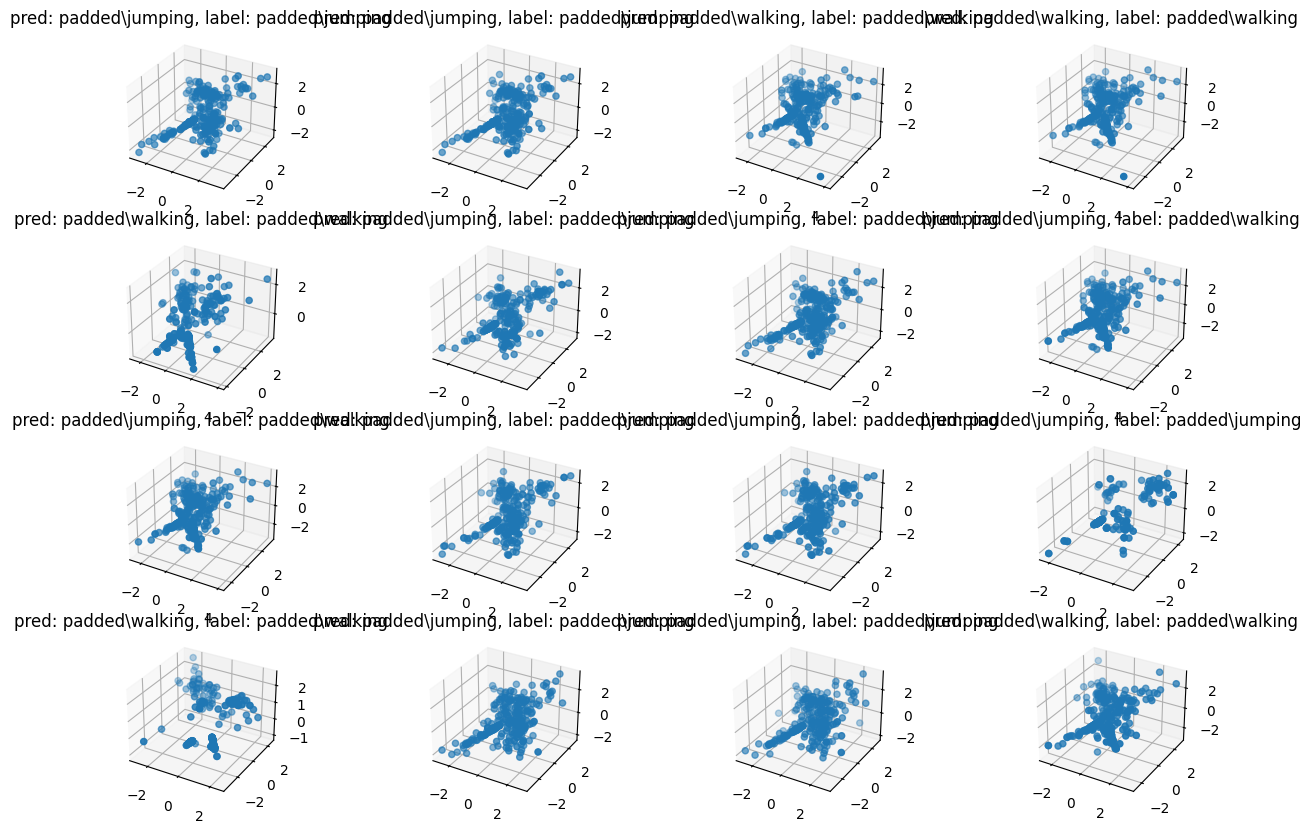

In [44]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:20, ...]
labels = labels[:20, ...]

# run test data through model
preds = model.predict(points)
preds = ops.argmax(preds, -1)

points = points.numpy()
print(points)

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_on()
plt.show()

In [45]:
predictions = []

# Calculate the number of sections, ensure it's at least 1
num_sections = max(1, len(test_points) // NUM_POINTS)
for batch in np.array_split(test_points, num_sections): 
    preds = model.predict(batch)
    preds = np.argmax(preds, axis=-1)
    predictions.extend(preds)

predictions = np.array(predictions)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [46]:
accuracy = np.sum(predictions == test_labels) / len(test_labels)
print(predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

[1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
Accuracy: 88.75%


In [47]:
print(test_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]


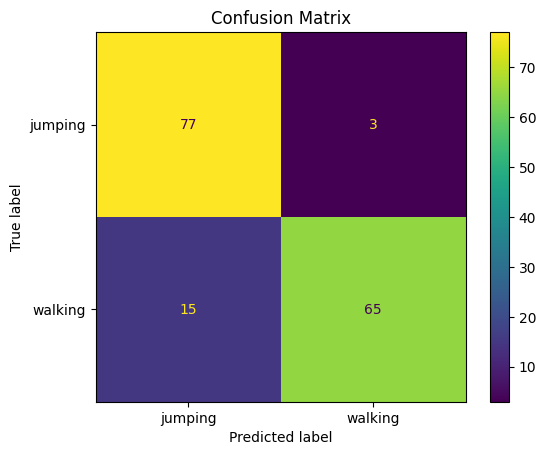

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Plotting the confusion matrix
# Compute the confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Plotting the confusion matrix
class_names = ['jumping', 'walking']  # Based on your CLASS_MAP
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)

# Display the plot
disp.plot()
plt.title("Confusion Matrix")
plt.show()


In [84]:
#reload model
reload_model = create_pointnet_model(input_shape, num_features)
reload_model.load_weights('./model/checkpoints/17_09_2024_pointlstm_padded_bg_rm/best.weights.h5')

In [51]:
file = "./cluster_data/padded/jumping/test/katie_point_taken_poss_matrix121.pkl"
# Load the data from the pickle file
with open(file, 'rb') as file:
    data = pickle.load(file)
data = np.array(data)
print(data.shape)


(10, 30, 5)


In [52]:
data = data.reshape(1, 300, 5)
print(data.shape)
data

(1, 300, 5)


array([[[  0.421875  ,   1.7578125 ,   0.42871094,  -0.62597656,
         317.        ],
        [  0.50878906,   1.77832031,   0.51171875,  -0.50097656,
         301.        ],
        [  0.53027344,   1.86816406,   0.87011719,   0.37573242,
         301.        ],
        ...,
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ]]])

In [55]:
predictions = []

# Calculate the number of sections, ensure it's at least 1
num_sections = max(1, len(data) // NUM_POINTS)

for batch in np.array_split(data, num_sections): 
    preds = reload_model.predict(batch)
    preds = np.argmax(preds, axis=-1)
    predictions.extend(preds)

predictions = np.array(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


In [57]:
pred = reload_model.predict(data)
print(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[[0.12037265 0.8796273 ]]
